In [1]:
!pip install allennlp torch tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!unzip "/content/drive/MyDrive/196.zip"

Archive:  /content/drive/MyDrive/196.zip
replace meta.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
from allennlp.modules.token_embedders import ElmoTokenEmbedder
from allennlp.data.token_indexers.elmo_indexer import ELMoTokenCharactersIndexer
from allennlp.data.tokenizers.token_class import Token
import torch
import numpy as np
from allennlp.data.vocabulary import Vocabulary
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
elmo_embedder = ElmoTokenEmbedder(options_file="options.json", weight_file="model.hdf5")
indexer = ELMoTokenCharactersIndexer()
vocab = Vocabulary()
vocab.set_from_file("tokens.txt", is_padded=False)

In [125]:
df = pd.read_csv("/content/drive/MyDrive/busines_norm.csv", index_col=0)
df.head()

,norm,title,text
421323,2,РЖД разрешит пассажирам путешествовать с автом...,"""Федеральная пассажирская компания"", входящая ..."
444694,0,РЖД впервые перевезла пассажиров с личными авт...,Вечером 26 ноября 2012 года из Москвы в Хельси...
450356,2,Крупнейший производитель часов в мире купил ог...,"Швейцарская Swatch Group, крупнейший в мире пр..."
450377,2,"""Дочка"" ""Росатома"" станет единоличным владельц...","Урановый холдинг ""Атомредметзолото"" (АРМЗ), до..."
450399,2,Временный руководитель крупнейшего ритейлера Р...,Наблюдательный совет крупнейшего ритейлера Рос...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9146 entries, 421323 to 800684
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   norm    9145 non-null   object
 1   title   9146 non-null   object
 2   text    9146 non-null   object
dtypes: object(3)
memory usage: 285.8+ KB


In [8]:
df = df[df.norm != "-"]
df.head()

,norm,title,text
421323,2,РЖД разрешит пассажирам путешествовать с автом...,"""Федеральная пассажирская компания"", входящая ..."
444694,0,РЖД впервые перевезла пассажиров с личными авт...,Вечером 26 ноября 2012 года из Москвы в Хельси...
450356,2,Крупнейший производитель часов в мире купил ог...,"Швейцарская Swatch Group, крупнейший в мире пр..."
450377,2,"""Дочка"" ""Росатома"" станет единоличным владельц...","Урановый холдинг ""Атомредметзолото"" (АРМЗ), до..."
450399,2,Временный руководитель крупнейшего ритейлера Р...,Наблюдательный совет крупнейшего ритейлера Рос...


In [10]:
df = df.dropna()

In [103]:
df["len_title"] = df.title.apply(lambda x: len(x.split()))

In [104]:
df.len_title.max()

14

In [21]:
a = np.array([[1,2,3,4], [1,2,3,4]])
a = np.append(a, np.zeros((4-len(a), 4))).reshape(4, 4)
a

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [105]:
from tensorflow.keras.utils import to_categorical
def preprocess(text, max_word):
  text = text.strip().replace("\n", " ").replace("\xa0", " ").lower()
  tokens = [Token(word) for word in text.split()[:max_word]]
  return tokens
def get_embedded(row):
  text = row["title"]
  tokens = preprocess(text, 20)
  character_indices = indexer.tokens_to_indices(tokens, vocab)["elmo_tokens"]
  indices_tensor = torch.LongTensor([character_indices])
  embeddings = elmo_embedder(indices_tensor)[0].detach().numpy()
  embeddings = np.append(embeddings, np.zeros((20 - len(embeddings), 1024))).reshape(20, 1024)
  return embeddings

In [27]:
len(df)

466

In [107]:
df = df.iloc[:1000, :]

In [108]:
df["embedded"] = df.apply(get_embedded, axis=1)
df.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,norm,title,text,len_title,embedded
421323,2,РЖД разрешит пассажирам путешествовать с автом...,"""Федеральная пассажирская компания"", входящая ...",6,"[[0.5357568264007568, -0.0, 0.0, -0.0, -1.5012..."
444694,0,РЖД впервые перевезла пассажиров с личными авт...,Вечером 26 ноября 2012 года из Москвы в Хельси...,7,"[[0.5317826271057129, -0.5637463331222534, 1.8..."
450356,2,Крупнейший производитель часов в мире купил ог...,"Швейцарская Swatch Group, крупнейший в мире пр...",9,"[[0.6726956367492676, -0.757212221622467, -0.0..."
450377,2,"""Дочка"" ""Росатома"" станет единоличным владельц...","Урановый холдинг ""Атомредметзолото"" (АРМЗ), до...",8,"[[-0.0, 1.9689425230026245, -1.218779683113098..."
450399,2,Временный руководитель крупнейшего ритейлера Р...,Наблюдательный совет крупнейшего ритейлера Рос...,7,"[[-0.0, 0.24332091212272644, 1.684971451759338..."


In [ ]:
def preprocess_text(text, max_len):
  return " ".join(text.strip().replace("\n", " ").replace("\xa0", " ").lower().split()[:max_len])

In [30]:
min_count = df.norm.value_counts().values[-1]
min_count

54

In [ ]:
df["clearText"] = df.apply(lambda x: preprocess_text(x["title"] + " " + x["text"], 100) , axis=1)

(20, 1024)    466
Name: shape_seq, dtype: int64

In [37]:
x = list()
y = list()
lable = {}
for i in range(len(df)):
  x.append(df.iloc[i, 4])
#   if not df.iloc[i,0] in lable:
#     lable[df.iloc[i,0]] = 0
#   if lable[df.iloc[i,0]] <= min_count:
#     x.append(df.iloc[i, 3])
#     y.append(df.iloc[i,0])
# lable[df.iloc[i,0]] += 1
x = np.array(x)


In [38]:
x.shape

(466, 20, 1024)

In [39]:
from sklearn.model_selection import train_test_split

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 421323 to 460899
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   norm       466 non-null    object
 1   title      466 non-null    object
 2   text       466 non-null    object
 3   embedded   466 non-null    object
 4   len_seq    466 non-null    int64 
 5   shape_seq  466 non-null    object
dtypes: int64(1), object(5)
memory usage: 25.5+ KB


In [40]:
df.head()

,norm,title,text,len_title,embedded,shape_seq
421323,2,РЖД разрешит пассажирам путешествовать с автом...,"""Федеральная пассажирская компания"", входящая ...",6,"[[0.5342742204666138, -0.5684240460395813, 0.0...","(20, 1024)"
444694,0,РЖД впервые перевезла пассажиров с личными авт...,Вечером 26 ноября 2012 года из Москвы в Хельси...,7,"[[0.0, -0.0, 0.0, -0.0, -0.0, -0.9882066249847...","(20, 1024)"
450356,2,Крупнейший производитель часов в мире купил ог...,"Швейцарская Swatch Group, крупнейший в мире пр...",9,"[[0.0, -0.0, -0.21814310550689697, -0.10593219...","(20, 1024)"
450377,2,"""Дочка"" ""Росатома"" станет единоличным владельц...","Урановый холдинг ""Атомредметзолото"" (АРМЗ), до...",8,"[[-0.0, 1.9689425230026245, -1.218779683113098...","(20, 1024)"
450399,2,Временный руководитель крупнейшего ритейлера Р...,Наблюдательный совет крупнейшего ритейлера Рос...,7,"[[-0.4367152154445648, 0.24332085251808167, 1....","(20, 1024)"


In [41]:
y = df.norm.to_numpy()
y = to_categorical(y, 4)
y[0]

array([0., 0., 1., 0.], dtype=float32)

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(256, input_shape=(20, 1024), return_sequences=True, activation="relu"),
    tf.keras.layers.GRU(128, activation="relu"),
    # Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), metrics=["accuracy"], loss=tf.keras.losses.CategoricalCrossentropy())
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 256)           984576    
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 4)                 132       
                                                                 
Total params: 1,143,268
Trainable params: 1,143,268
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

In [45]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=".")

In [ ]:
!tensorboard --logdir="."

2022-10-08 17:46:36.663814: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=32, callbacks=[tensorboard]).history

In [164]:
model.save("model_title.h5")

In [109]:
df["flatten_embed"] = df.embedded.apply(lambda x: x.flatten())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [110]:
mat = np.matrix([x for x in df.flatten_embed])

In [ ]:
from sklearn.manifold import TSNE

In [120]:
TSNEmodel = TSNE(n_components=3)
low_dim_data = TSNEmodel.fit_transform(mat)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [79]:
import seaborn as sns
import plotly.express as ex

In [117]:
df = df.fillna("-")

In [121]:
tsne_df =  pd.DataFrame(low_dim_data, df.norm)
tsne_df.head()

,0,1,2
norm,,,
2,81.950005,27.424049,47.846779
0,101.548782,12.726271,40.949463
2,-40.051514,26.774368,26.781713
2,-18.218452,-52.235012,-36.580940
2,-35.989864,113.246086,-80.614845


In [123]:
tsne_df.columns = ['x','y', "z"]
ex.scatter_3d(tsne_df, x='x', y='y', z="z", color=tsne_df.index)

In [126]:
!pip install mpld3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 5.1 MB/s 


In [127]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl

In [128]:
titles = df.title.to_numpy()

In [130]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
nltk.download('punkt')
def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def token_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#Создаем словари (массивы) из полученных основ
totalvocab_stem = []
totalvocab_token = []
for i in titles:
    allwords_stemmed = token_and_stem(i)
    #print(allwords_stemmed)
    totalvocab_stem.extend(allwords_stemmed)
    
    allwords_tokenized = token_only(i)
    totalvocab_token.extend(allwords_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [132]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 9.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=159a78fab670c4e907ef0e243b3643f1867ba4c9a5c375f431ba9c7dd479740f
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [133]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

G=[]

for i in titles:
    h=i.split(' ')
    #print(h)
    s=''
    for k in h:
        #print(k)
        p = morph.parse(k)[0].normal_form
        #print(p)
        s+=' '
        s += p
        #print(s)
        #G.append(p)
    #print(s)
    G.append(s)

pymof = open('pymof_pod.txt', 'w', encoding='utf-8', errors='ignore')
pymofcsv = open('pymofcsv_pod.csv', 'w', encoding='utf-8', errors='ignore')
for item in G:
    pymof.write("%s\n" % item)
    pymofcsv.write("%s\n" % item)
pymof.close()
pymofcsv.close()

In [134]:
!pip install pymystem3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
from pymystem3 import Mystem
m = Mystem()
A = []

for i in titles:
    #print(i)
    lemmas = m.lemmatize(i)
    A.append(lemmas)

#Этот массив можно сохранить в файл либо "забэкапить"
import pickle
with open("mystem.pkl", 'wb') as handle:
                    pickle.dump(A, handle)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


KeyboardInterrupt: ignored

In [137]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=token_and_stem, ngram_range=(1,3))
get_ipython().magic('time tfidf_matrix = tfidf_vectorizer.fit_transform(titles)')
print(tfidf_matrix.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.



CPU times: user 7.47 s, sys: 95.7 ms, total: 7.57 s
Wall time: 9.4 s
(9146, 79)


In [138]:
num_clusters = 4

# Метод к-средних - KMeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
get_ipython().magic('time km.fit(tfidf_matrix)')
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

print(clusters)
print (km.labels_)


CPU times: user 213 ms, sys: 1.11 ms, total: 214 ms
Wall time: 224 ms
[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [139]:
# MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans

mbk  = MiniBatchKMeans(init='random', n_clusters=num_clusters) #(init='k-means++', ‘random’ or an ndarray)
mbk.fit_transform(tfidf_matrix)
%time mbk.fit(tfidf_matrix)
miniclusters = mbk.labels_.tolist()
print (mbk.labels_)


CPU times: user 43.6 ms, sys: 3.85 ms, total: 47.5 ms
Wall time: 93.8 ms
[0 0 0 ... 3 0 1]


In [140]:
# DBSCAN
from sklearn.cluster import DBSCAN
get_ipython().magic('time db = DBSCAN(eps=0.3, min_samples=10).fit(tfidf_matrix)')
labels = db.labels_
labels.shape
print(labels)

CPU times: user 972 ms, sys: 1.51 s, total: 2.48 s
Wall time: 3.38 s
[ 0  0 -1 ... -1 -1 -1]


In [141]:
# Аггломеративная класстеризация
from sklearn.cluster import AgglomerativeClustering

agglo1 = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean') #affinity можно выбрать любое или попробовать все по очереди: cosine, l1, l2, manhattan
get_ipython().magic('time answer = agglo1.fit_predict(tfidf_matrix.toarray())')
answer.shape

CPU times: user 8.37 s, sys: 67.6 ms, total: 8.44 s
Wall time: 10.5 s


(9146,)

In [142]:
#k-means
clusterkm = km.labels_.tolist()
#minikmeans
clustermbk = mbk.labels_.tolist()
#dbscan
clusters3 = labels
 #agglo
#clusters4 = answer.tolist()

frame = pd.DataFrame(titles, index = [clusterkm])

#k-means
out = { 'title': titles, 'cluster': clusterkm }
frame1 = pd.DataFrame(out, index = [clusterkm], columns = ['title', 'cluster'])

#mini
out = { 'title': titles, 'cluster': clustermbk }
frame_minik = pd.DataFrame(out, index = [clustermbk], columns = ['title', 'cluster'])

frame1['cluster'].value_counts()
frame_minik['cluster'].value_counts()

0    5389
2    2918
3     468
1     371
Name: cluster, dtype: int64

In [143]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

(9146, 9146)

In [144]:
# Метод главных компонент - PCA

from sklearn.decomposition import IncrementalPCA
icpa = IncrementalPCA(n_components=2, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
get_ipython().magic('time demo2 = icpa.transform(dist)')
xs, ys = demo2[:, 0], demo2[:, 1]

# PCA 3D
from sklearn.decomposition import IncrementalPCA
icpa = IncrementalPCA(n_components=3, batch_size=16)
get_ipython().magic('time icpa.fit(dist) #demo =')
get_ipython().magic('time ddd = icpa.transform(dist)')
xs, ys, zs = ddd[:, 0], ddd[:, 1], ddd[:, 2]

#Можно сразу примерно посмотреть, что получится в итоге
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs, ys, zs)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#plt.show()

CPU times: user 15 s, sys: 7.25 s, total: 22.3 s
Wall time: 13.1 s
CPU times: user 625 ms, sys: 130 ms, total: 755 ms
Wall time: 459 ms
CPU times: user 15.8 s, sys: 6.44 s, total: 22.3 s
Wall time: 11.7 s
CPU times: user 661 ms, sys: 124 ms, total: 785 ms
Wall time: 479 ms


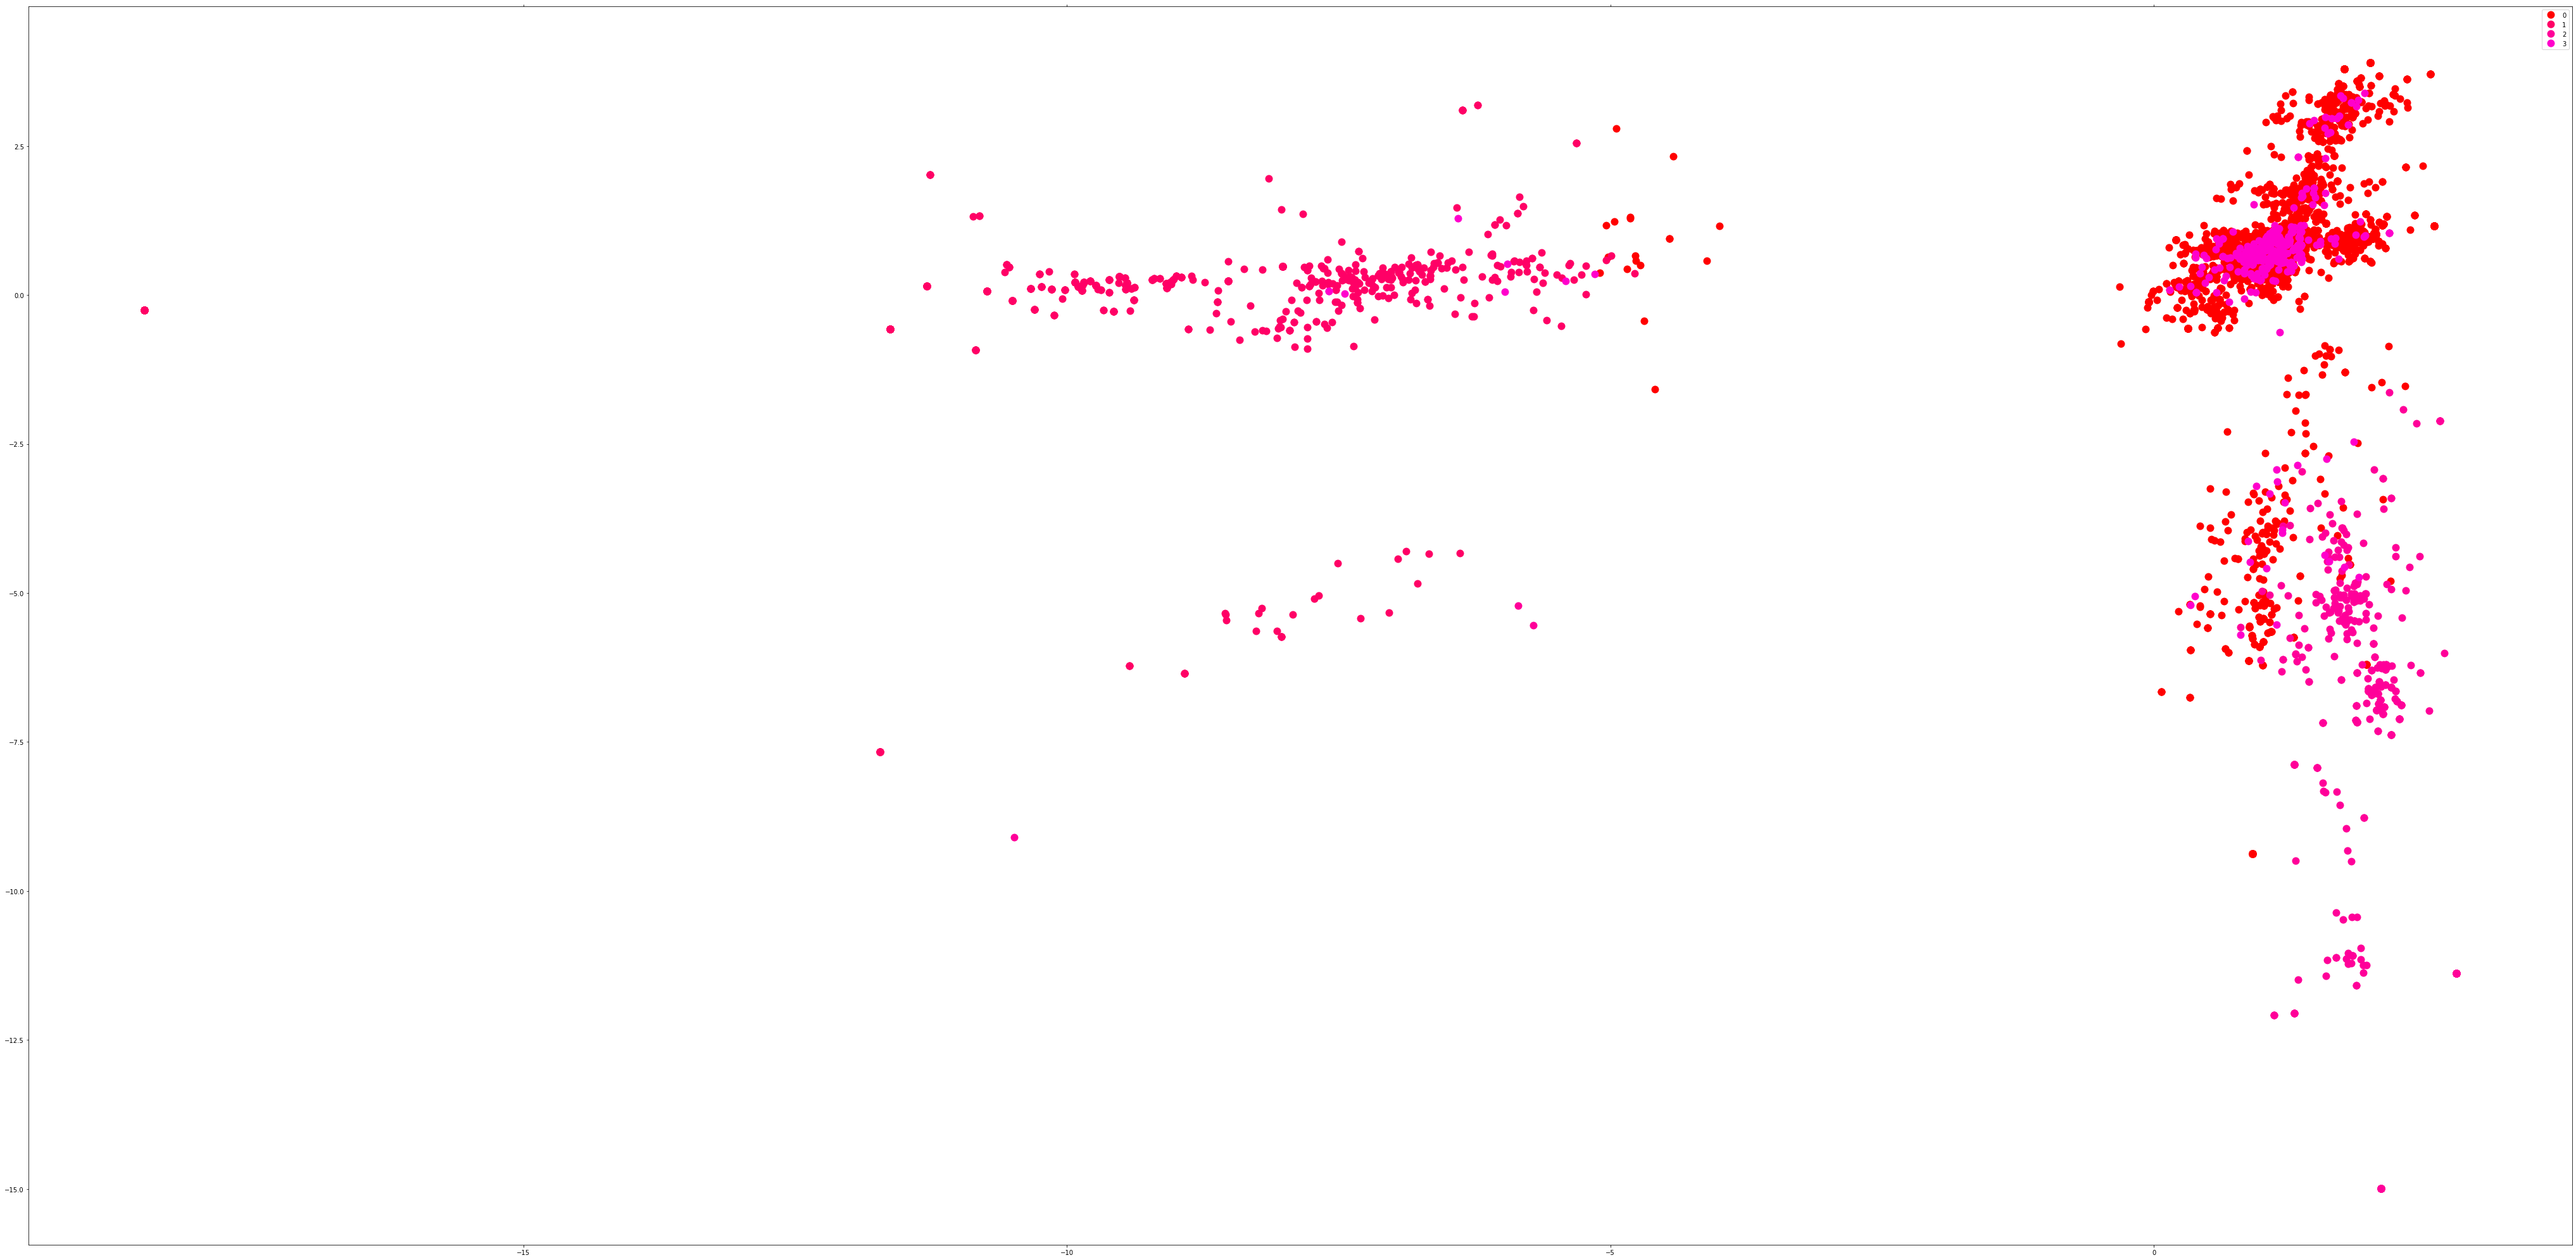

In [158]:
from matplotlib import rc
#включаем русские символы на графике
font = {'family' : 'Verdana'}#, 'weigth': 'normal'}
rc('font', **font)

#можно сгенерировать цвета для кластеров
import random
def generate_colors(n):
    color_list = []
    for c in range(0,n):
        r = lambda: random.randint(0,255)
        color_list.append( '#%02X%02X%02X' % (r(),r(),r()) )
    return color_list

#устанавливаем цвета
cluster_colors = {0: '#ff0000', 1: '#ff0066', 2: '#ff0099',  3: '#ff00cc', 4: '#ff00ff',}
#даем имена кластерам, но из-за рандома пусть будут просто 01234
cluster_names = {0: '0',  1: '1', 2: '2',  3: '3', 4: '4',}
#matplotlib inline

#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=xs, y=ys, label=clusterkm, title=titles)) 
#группируем по кластерам
groups = df.groupby('label')

#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=xs, y=ys, label=clustermbk, title=titles)) 
#группируем по кластерам
groups_mbk = df.groupby('label')

fig, ax = plt.subplots(figsize=(72, 36)) #figsize подбирается под ваш вкус

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1)  #показать легенду только 1 точки

#добавляем метки/названия в х,у позиции с поисковым запросом
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=6)  

#показать график
plt.show() 
plt.close()

In [159]:
mbk.cluster_centers_

array([[1.45121088e-02, 1.64032881e-02, 1.17232749e-02, 1.42516027e-02,
        1.35199022e-02, 1.29182922e-02, 1.31762379e-02, 1.10270607e-02,
        0.00000000e+00, 1.97140891e-02, 1.02340090e-02, 1.67653789e-02,
        9.18259250e-03, 1.44272699e-02, 1.03457580e-02, 1.36626042e-03,
        2.09093841e-02, 1.35335542e-02, 1.23885299e-02, 7.63926835e-03,
        1.48669150e-03, 1.36571395e-02, 1.34671531e-02, 1.08488442e-02,
        1.54875896e-02, 1.06818501e-03, 0.00000000e+00, 6.50119628e-05,
        1.93043319e-03, 0.00000000e+00, 1.48877455e-02, 1.48953041e-02,
        8.30733150e-03, 1.26738234e-02, 7.66301886e-03, 0.00000000e+00,
        1.22121952e-02, 1.39904620e-02, 5.87273135e-03, 1.55277075e-02,
        9.95749547e-03, 7.21805653e-03, 1.04692716e-02, 7.40609864e-03,
        8.70546899e-03, 6.12631681e-03, 3.24839827e-03, 0.00000000e+00,
        8.53312739e-05, 1.01751751e-02, 9.00380212e-03, 1.80115262e-02,
        5.80203901e-04, 1.54171191e-02, 1.13822811e-02, 1.736927

NameError: ignored

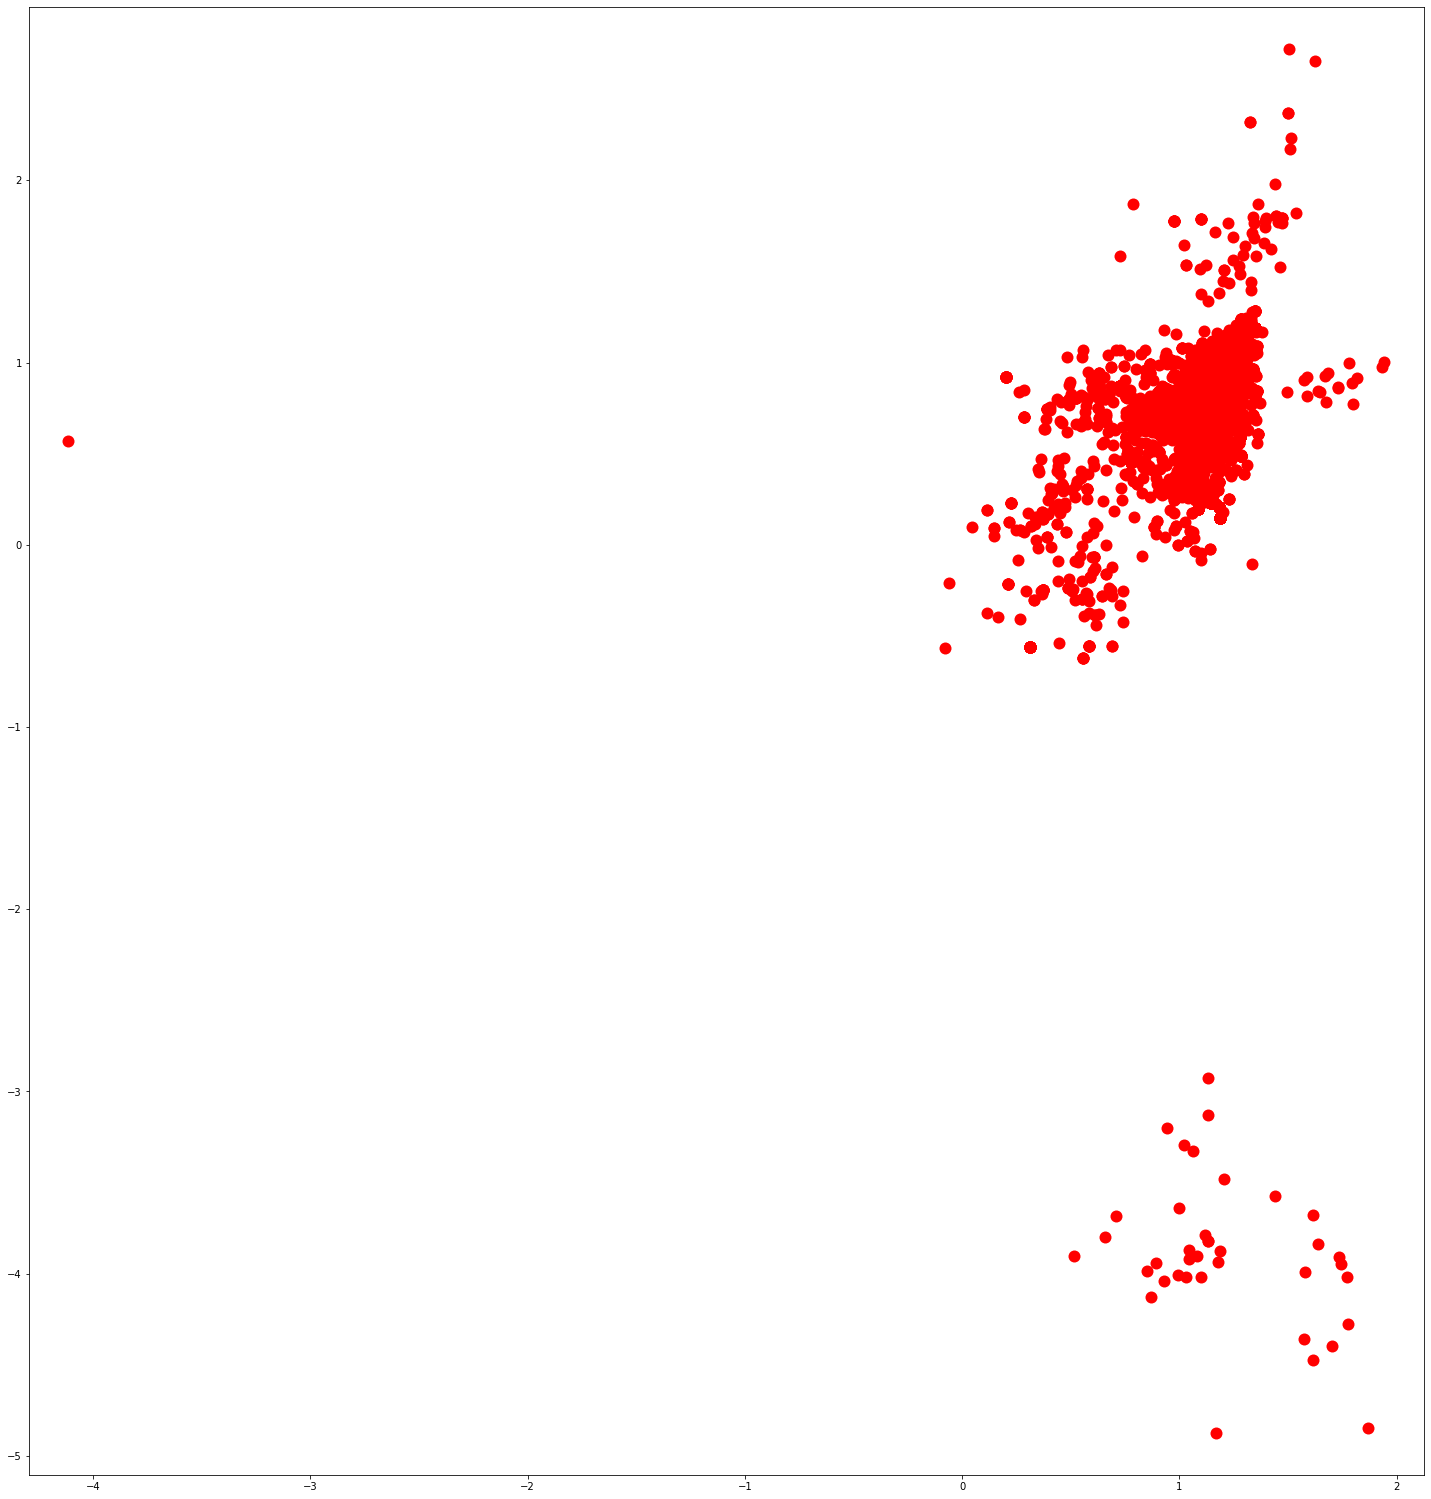

In [160]:
# Plot 
fig, ax = plt.subplots(figsize=(25,27)) 
ax.margins(0.03)


for name, group in groups_mbk:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, #ms=18
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels, voffset=10, hoffset=10, css=css)
    mpld3.plugins.connect(fig, tooltip) #   , TopToolbar()
    
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)

ax.set_title("Mini K-Means", size=20) #groups_mbk
    
ax.legend(numpoints=1)
mpld3.disable_notebook()
#mpld3.display()
mpld3.save_html(fig, "mbk.html")

mpld3.show()
#mpld3.save_json(fig, "vivod.json")
#mpld3.fig_to_html(fig)

fig, ax = plt.subplots(figsize=(51,25))

scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s=1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')    

ax.set_title("Кластеры", size=20)

fig, ax = plt.subplots(figsize=(51,25))

labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()
fig, ax = plt.subplots(figsize=(72,36))
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    tooltip = mpld3.plugins.PointLabelTooltip(points, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

ax.set_title("K-means", size=20)

mpld3.display()

In [154]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=8227a61015e383a635b6fb5d9eaa5e65a0294a2c1f506d3df9d5a1d6695b9217
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [161]:
import plotly
plotly.__version__

import chart_studio.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='cluster-3d-plot')

PlotlyRequestError: ignored

RecursionError: ignored

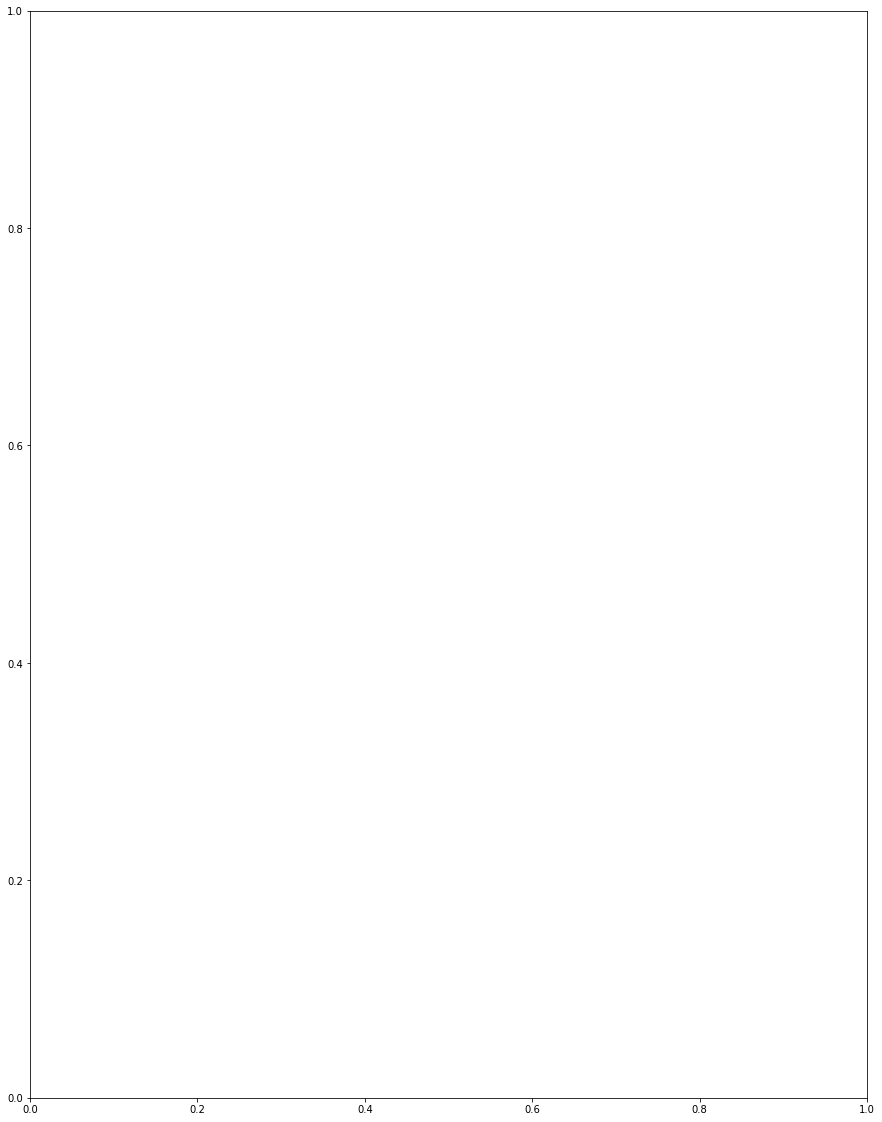

In [162]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',
    which='both', 
    bottom='off',
    top='off',
    labelbottom='off')

plt.tight_layout() 

#сохраним рисунок
plt.savefig('ward_clusters2.png', dpi=200)